In [11]:
%matplotlib inline 
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf

In [6]:
import time

In [26]:
import numpy as np

In [9]:
%prun 

In [8]:
from evaluation_utils import read_text_lines, read_file_data, generate_depth_map

In [9]:
from tfrecord_utils import write_to_tfrecord, read_tfrecord, write_to_tfrecord_multi

In [10]:
import os, os.path

# Taken from https://stackoverflow.com/a/600612/119527
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if os.path.isdir(path):
            pass
        else: raise

In [11]:
test_files = read_text_lines( "%s/%s" % ('filenames','eigen_train_files.txt') )

In [14]:
gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(test_files[:20], '/data/gengshay/KITTI/')

0 files missing


In [15]:
sep1 = gt_files[0].find('sync') + 4
sep2 = im_files[0].find('.jpg') -11

str1 = gt_files[0][:sep1]
dir1 = '%s/%s' % (str1, 'depth')
mkdir_p(dir1)
imname = im_files[0][sep2:]
depth_path = '%s/%s' % (dir1,imname)

In [16]:
depth_path

'/data/gengshay/KITTI/2011_09_28/2011_09_28_drive_0001_sync/depth//0000000105.jpg'

In [12]:
depths = []
beg = time.time()
for t_id in range(len(gt_files)):
    depth = generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], cams[t_id], False, True)
    depths.append(depth)
print '%ds' % (time.time()-beg)

0s


In [19]:
tfrecord_file = '/scratch/gengshay/eigen_train_depth.tfrecord'
labels = [1]*20
images = [np.asarray(depth, np.uint8) for depth in depths]
shapes = [np.array(depth.shape, np.int32) for depth in depths]

In [20]:
write_to_tfrecord_multi(labels, [shape.tobytes() for shape in shapes], [image.tobytes() for image in images], tfrecord_file)

In [ ]:
label, shape, image = read_from_tfrecord([tfrecord_file])

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    label, image, shape = sess.run([label, image, shape])
    coord.request_stop()
    coord.join(threads)
print(label)
print(shape)
plt.imshow(image)
plt.show() 

1
[ 370 1224]


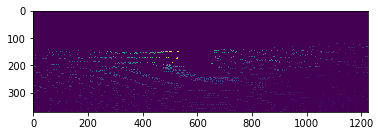

In [18]:
read_tfrecord(tfrecord_file)

In [15]:
tfrecord_file = 'eigen_train_depth.tfrecord'
label = 1
image = np.asarray(depth, np.uint8)
shape = np.array(depth.shape, np.int32)

In [16]:
write_to_tfrecord(label, shape.tobytes(), image.tobytes(), tfrecord_file)

In [2]:
import tensorflow as tf

In [6]:
with tf.Session() as sess:
    a=tf.convert_to_tensor('/data/gengshay/KITTI/2011_09_28/2011_09_28_drive_0001_sync/image_00/data/0000000105.jpg')
    tmp = tf.string_split([a],tf.convert_to_tensor('/'))
    f = tf.string_join( ['/']+[tmp.values[0], tmp.values[1], tmp.values[2], tmp.values[3],tmp.values[4]] + [tf.convert_to_tensor('depth')] +\
                         [tmp.values[-1]], '/')
    #f = tf.string_join(tmp.values[:-3] +  [tf.convert_to_tensor('depth')] +\
    #                       [tmp.values[-1]], '/')
    print f.eval()

//data/gengshay/KITTI/2011_09_28/2011_09_28_drive_0001_sync/depth/0000000105.jpg


In [5]:
i = tf.constant(0)
p = tf.constant(1)

def body(i):
    # do something here which you want to do in your loop
    # increment i
     # print tmp.values[i].eval()
    return [tf.add(i, 1)]
r = tf.while_loop(lambda i: tf.less(i, 5), body, [i])
with tf.Session() as sess:

    print r.eval()
    print p.eval()

5
1


In [101]:
with tf.Session() as sess:
    image_path = tf.convert_to_tensor('/ssd0/KITTI/2011_09_26/2011_09_26_drive_0039_sync/image_00/data/0000000000.jpg')
    lidar_path = tf.convert_to_tensor('/ssd0/KITTI/2011_09_26/2011_09_26_drive_0039_sync/disp_0/0000000000.jpg')
    # image_path = tf.convert_to_tensor('/scratch/gengshay/KITTI/2011_09_26/2011_09_26_drive_0039_sync/depth/0000000000.jpg')
    image = tf.image.decode_jpeg(tf.read_file(image_path))
    lidar = tf.image.decode_jpeg(tf.read_file(lidar_path))
    image = tf.image.resize_images(image,  [256, 512], tf.image.ResizeMethod.AREA)
    lidar = tf.image.resize_images(lidar,  [256, 512], tf.image.ResizeMethod.AREA)
    # image = tf.divide(image, tf.cast(tf.shape(image)[1],tf.float32))
    image.set_shape( [None, None, 1])
    lidar.set_shape( [None, None, 1])
    mask = lidar > 0;
    lidar_masked = tf.boolean_mask(lidar,mask)
    image_masked = tf.boolean_mask(image,mask)
    sup_loss = tf.abs(lidar_masked - image_masked)
    sup_loss = tf.reduce_mean(sup_loss)
    t = sup_loss.eval()
    a =  lidar_masked.eval()
    b = image_masked.eval()

In [102]:
t

166.87125

In [92]:
a.shape

(63028,)

TypeError: Invalid dimensions for image data

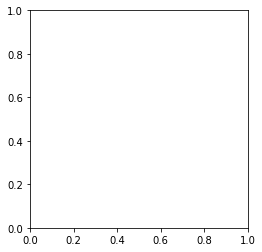

In [93]:
plt.imshow(a.reshape())